In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls /content/drive/My\ Drive/giraffe
!cp /content/drive/My\ Drive/giraffe/data.zip data.zip
!unzip data.zip
!ls
dataset_path = '/content/drive/My Drive/giraffe/dataset_20000_128.hdf5'

dataset_10000.hdf5  dataset_20000_128.hdf5  train
dataset_1000.hdf5   dataset_50000.hdf5


In [0]:
import torch
from torch import nn
from torch.utils.data import random_split, Dataset
from torchvision import transforms
from torch.autograd import Variable
import torchvision
import numpy as np
import h5py
from PIL import Image

In [0]:
class RayTracingDecoder(nn.Module):
    def __init__(self):
        super(RayTracingDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(29, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 256 * 256 * 3),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.decoder(x)
        return x

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=3, padding=1),  # b, 32, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 32, 5, 5
            nn.Conv2d(32, 16, 3, stride=2, padding=1),  # b, 16, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 16, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 6, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [0]:
def load_dataset(path):
    with h5py.File(path, "r") as f:
        rgb = np.array(f["renders"])
        scenes = np.array(f["scenes"]).astype(np.uint8)
        # print(scenes[0])
        for index, img in enumerate(rgb):
            im = Image.fromarray(img)
            if index == 0:
              # im.show()
              im.save('example.png')
        return scenes, rgb

class RayTracingDataset(Dataset):

    def __init__(self, scenes, renders, transform=None):
        '''
        Args:
            scenes (Numpy array)
            renders (Numpy array)
            transform (callable, optional)
        '''
        self.scenes = scenes
        self.renders = renders
        self.transform = transform
    
    def __len__(self):
        return len(self.scenes)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = {'scene': self.scenes[idx],
                  'render': self.renders[idx]}

        return sample


In [57]:
split_factor = 0.8

# load the dataset
scenes, rgb = load_dataset(dataset_path)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

rt_dataset = RayTracingDataset(scenes=scenes, renders=rgb, transform=img_transform)
print("Dataset length is {}.".format(len(rt_dataset)))

dataset_split_size = [int(len(rt_dataset) * split_factor), 
                        len(rt_dataset) - int(len(rt_dataset) * split_factor)]



# split the dataset into train and test
train_dataset, test_dataset = random_split(rt_dataset, dataset_split_size)

b_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=b_size, shuffle=True, num_workers=4,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=b_size, shuffle=False, num_workers=4
)


num_epochs = 200
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

# model = RayTracingDecoder().float()
model = AE(input_shape=49152).cuda()
# model = autoencoder().cuda()
# model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, 
    weight_decay=1e-5
)


Dataset length is 20000.


epoch [1/200], loss:2534.5454
epoch [11/200], loss:2214.4509
epoch [21/200], loss:2354.6470
epoch [31/200], loss:2198.2615
epoch [41/200], loss:2147.3257
epoch [51/200], loss:2107.2578
epoch [61/200], loss:2124.6150
epoch [71/200], loss:2123.4207
epoch [81/200], loss:2095.4873
epoch [91/200], loss:2286.8208
epoch [101/200], loss:2100.7773
epoch [111/200], loss:2041.2566
epoch [121/200], loss:2217.5195
epoch [131/200], loss:2217.4302
epoch [141/200], loss:2196.8154
epoch [151/200], loss:2250.8345
epoch [161/200], loss:2259.3433
epoch [171/200], loss:2156.7275
epoch [181/200], loss:2311.9907
epoch [191/200], loss:2223.3152


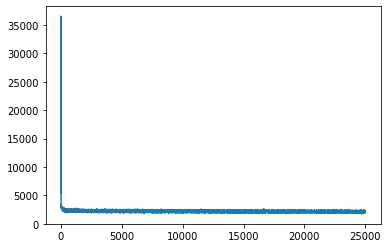

In [58]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 128, 128)
    return x

from torchvision.utils import save_image

losses = []
for epoch in range(num_epochs):
    for data in train_loader:

        render = data['render'].float()
        scene = data['scene'].float()

        # render = render.view(-1, 3, 128, 128)

        render = render.view(render.size(0), -1)

        render = Variable(render).to(device)
        scene = Variable(scene).to(device)

        # print(render.shape)

        output = model(render)

        # print(output.shape)

        loss = criterion(output, render)
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    if epoch % 10 == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))
        pic = to_img(output.cpu().data)
        save_image(pic, '/content/drive/My Drive/giraffe/train/{}.png'.format(str(epoch+1)))
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()
torch.save(model.state_dict(), '/content/drive/My Drive/giraffe/train/checkpoint.pth')